## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module_alt as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 2
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 64    #16384 #32768
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.00002
    ,learningRateG = 0.00002
)

sg.DCfg = sg.DCfgClass(16)


### <font style="color:lightblue">Raw Read</font>

In [4]:
trainSet = sg.createTrainSet()
prepGdLoss=0
testSet = sg.createTestSet()

Loaded set 4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft


### <font style="color:lightblue">Show</font>

-4.105e-01, 5.013e-03, -4.278e-01, -3.891e-01


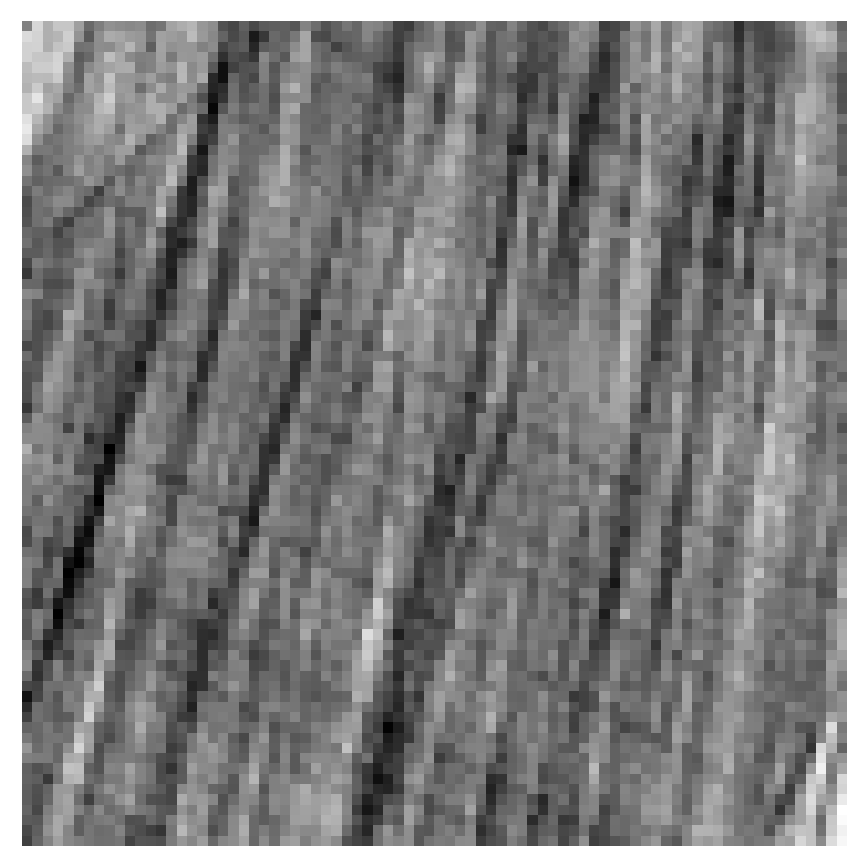

In [5]:
sg.refImages, sg.refNoises = sg.createReferences(trainSet, 0)
sg.showMe(trainSet, 0 )

## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)
        self.encoders =  nn.ModuleList([
            self.encblock(  1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 1, 3),
            self.encblock(  1, 1, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gen2.pt" )


    def forward(self, input):

        images, _ = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        minv = modelIn.min(dim=-1).values.min(dim=-1).values
        ampl = modelIn.max(dim=-1).values.max(dim=-1).values - minv
        minv = minv[:,:,None,None]
        ampl = ampl[:,:,None,None]
        iampl = torch.where(ampl==0, 0, 2/ampl)
        modelIn = ( modelIn - minv ) * iampl - 1 # stretch

        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn), dim=1 ))

        patches = ( 2*res[self.gapRng] + modelIn[:,[0],:, self.gapRngX] + 1 ) * ampl / 2 + minv #destretch
        return sg.squeezeOrg(patches, orgDims)




### Generator 4pix

In [7]:


class Generator4(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator4, self).__init__(4)
        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3),
            self.encblock( 2, 4, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(8, 2, 3),
            self.decblock(4, 2, 3),
            self.decblock(4, 1, 4, stride=2),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gen4.pt" )
        self.lowResGen = Generator2()


    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))

        patches = modelIn[self.gapRng] + 2 * res[self.gapRng]
        return sg.squeezeOrg(patches, orgDims)



### Generator 8pix

In [8]:


class Generator8(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator8, self).__init__(8)

        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3, dopadding=True),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3, dopadding=True),
            self.encblock( 2, 4, 3, stride=2),
            self.encblock( 4, 4, 3, dopadding=True),
            self.encblock( 4, 8, 3, stride=2),
            self.encblock( 8, 8, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(16, 8, 3, dopadding=True),
            self.decblock(16, 4, 4, stride=2),
            self.decblock( 8, 4, 3, dopadding=True),
            self.decblock( 8, 2, 4, stride=2),
            self.decblock( 4, 2, 3, dopadding=True),
            self.decblock( 4, 1, 4, stride=2),
            self.decblock( 2, 1, 3, dopadding=True),
            self.decblock( 2, 1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gen8.pt" )
        self.lowResGen = Generator4()



### <font style="color:lightblue">Generator</font>

In [9]:


class Generator16(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator16, self).__init__(16)

        self.encoders =  nn.ModuleList([
            self.encblock( (1 + self.latentChannels)/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        sg.load_model(self, model_path="saves/gap16/pureRec_trainLast/model_gen.pt" )
        self.lowResGen = Generator8()



sg.generator = Generator16()
sg.generator.to(sg.TCfg.device)
curgen = sg.generator
while hasattr(curgen, 'lowResGen') :
    sg.lowResGenerators[curgen.lowResGen.gapW] = curgen.lowResGen
    curgen = curgen.lowResGen
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)

sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)





/home/user/usr/src/sinogap/sinogap_module.py:247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=TCfg.device))


Layer (type:depth-idx)                                  Output Shape              Param #
Generator16                                             [1, 1, 80, 16]            --
├─Generator8: 1-1                                       --                        --
│    └─Generator4: 2-1                                  --                        --
│    │    └─Generator2: 3-1                             --                        2,395,650
│    │    └─ModuleList: 3-2                             --                        555,328
│    │    └─Sequential: 3-3                             [1, 256, 3, 3]            10,621,440
│    │    └─ModuleList: 3-4                             --                        1,295,552
│    │    └─Sequential: 3-5                             [1, 1, 20, 20]            66
│    └─ModuleList: 2-2                                  --                        --
│    │    └─Sequential: 3-6                             [1, 64, 38, 38]           640
│    │    └─Sequential: 3-7     

### <font style="color:lightblue">Discriminator</font>

In [10]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



### <font style="color:lightblue">Optimizers</font>

In [11]:
#sg.optimizer_G , sg.optimizer_D = sg.createOptimizers()

## <font style="color:lightblue">Restore checkpoint</font>

/home/user/usr/src/sinogap/sinogap_module.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkPoint = torch.load(path, map_location=TCfg.device)


Probabilities of reference images: Ref: 0.000e+00, Gen: 0.000e+00, Pre: 0.000e+00.
Distances of reference images: REC: 2.530e-03, MSE: 2.530e-03, L1L: 2.991e-02.


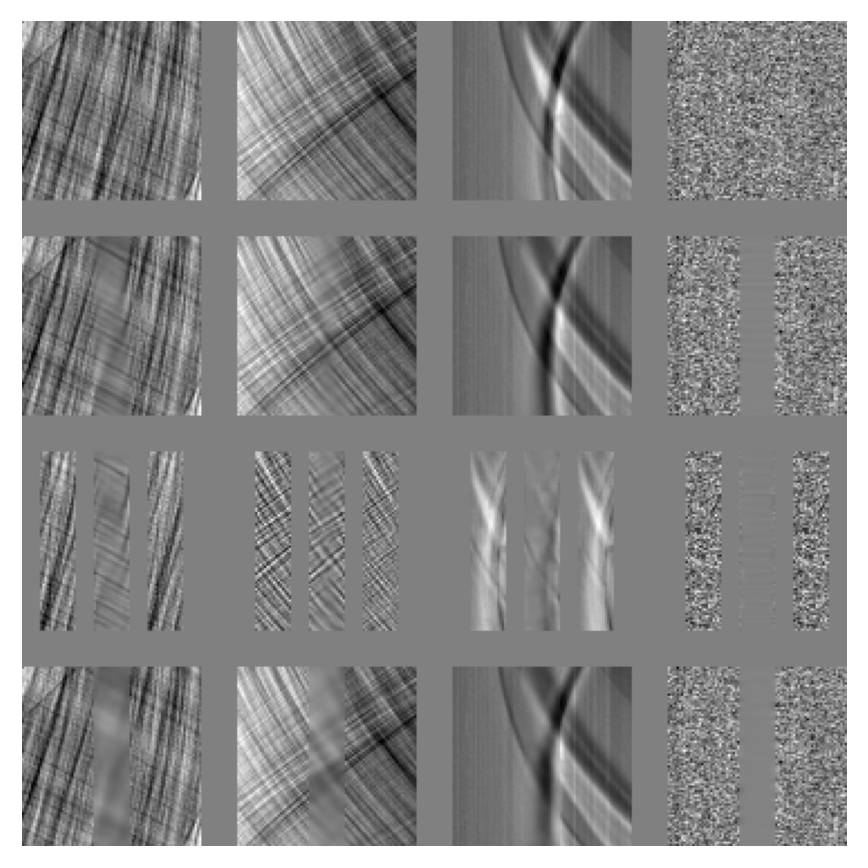

In [12]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss = sg.restoreCheckpoint(savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 9 (7).  L1L: 3.369e-02  MSE: 3.150e-03  Rec: 2.520e-03 (2.517e-03 / 2.711e-03).
TT: 0.00 (638213,991),  FT: 0.00 (3306120,865),  HD: 1.300e-02 (4026978,223),  GP: 0.000, 0.000 
TF: 0.00 (1829692,1754),  FF: 0.00 (795654,506),  LD: 4.576e-06 (2219492,207),  R : 0.000.


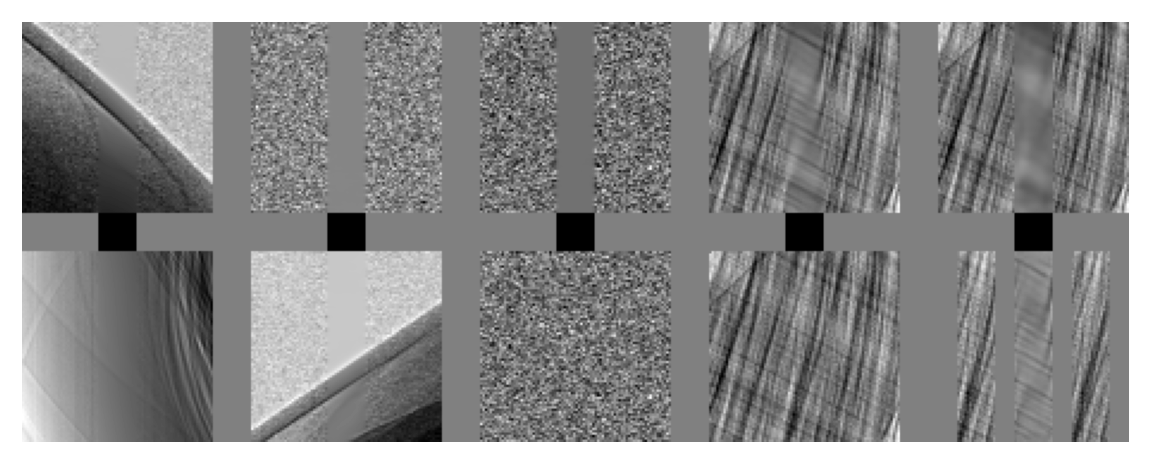

 77%|███████▋  | 62500/81544 [5:15:42<1:36:34,  3.29it/s]

In [ ]:

sg.TCfg.batchSize = 64
sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=8)
sg.testLoader = sg.createTestLoader(testSet, num_workers=8)
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader)
##Summary. Rec: 2.203e-03, MSE: 2.203e-03, L1L: 1.882e-02.
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, 0 )
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader, False)
##Summary. Rec: 2.190e-03, MSE: 2.190e-03, L1L: 1.854e-02
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, sg.epoch )

#torch.autograd.set_detect_anomaly(True)
#Summary. Rec: 2.711e-03, MSE: 2.711e-03, L1L: 3.165e-02.
Rec_diff, MSE_diff, L1L_diff = 2.711e-03, 2.711e-03, 3.165e-02
sg.prepGdLoss =  Rec_diff
if Rec_diff == 0:
    Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.dataLoader)
if not sg.epoch :
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE': MSE_diff
                          ,'L1L': L1L_diff
                          ,'REC': Rec_diff
                          }, 0 )

#minGdLossToKeep = sg.minGdLoss
#startingEpoch=sg.epoch
#def my_afterEachEpoch(epoch) :
#    global startingEpoch, minGdLossToKeep
#    if sg.minGEpoch < startingEpoch+2 and sg.minGdLoss < minGdLossToKeep :
#        sg.minGdLoss = minGdLossToKeep
#        return
#    for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#        item['lr'] *= 0.99
#sg.afterEachEpoch = my_afterEachEpoch

#
#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch

sg.noAdv = True

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    raise


 # purely diff, all pretrained, train all

## <font style="color:lightblue">Post</font>

In [ ]:
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()